In [515]:
import geopandas as gpd
import duckdb
from graph_tool.all import Graph, remove_parallel_edges, GraphView
from graph_tool.draw import graph_draw
from graph_tool.centrality import eigenvector
from graph_tool import load_graph, show_config
from graph_tool.topology import label_components
from shapely.geometry import MultiLineString, LineString
import numpy as np
import random

In [453]:
gdf = gpd.read_file('transmission_lines.geojson')

In [456]:
exploded = gdf.explode()

/tmp/ipykernel_18588/2932152834.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = gdf.explode()


In [492]:
usa = exploded.cx[-130:-40, 25:55]

In [502]:
usa['vertex_one'] = usa['geometry'].apply(lambda x: ', '.join(map(str, x.coords[0])))
usa['vertex_two'] = usa['geometry'].apply(lambda x: ', '.join(map(str, x.coords[-1])))

/home/kerple/miniconda3/envs/transmission_lines/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kerple/miniconda3/envs/transmission_lines/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [518]:
data = usa[['ID', 'TYPE', 'VOLTAGE', 'VOLT_CLASS', 'SHAPE_Length', 'vertex_one', 'vertex_two']].to_dict()

In [519]:
edge_list = zip(data['vertex_one'].values(), data['vertex_two'].values())

In [520]:
g = Graph(edge_list, hashed=True)

In [528]:
np.unique(label_components(g)[1])

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   43,   45,   46,   48,   50,
         51,   57,   59,   60,   63,   69,   72,   74,   94,   98,  111,
        112,  113,  119,  126,  127,  134,  153,  182,  193,  299,  306,
        369,  548,  788, 1087, 1303], dtype=uint64)

In [533]:
list(g.vp.ids)

['-70.9285537, 42.54359',
 '-70.9284093, 42.5441055',
 '-82.961231, 36.3769931',
 '-82.8078841, 36.4607057',
 '-75.3340663, 43.0894616',
 '-75.3444945, 43.1239924',
 '-89.9372786, 30.0090511',
 '-89.8974078, 30.0389191',
 '-90.5660876, 41.6125604',
 '-90.529538, 41.644519',
 '-86.8321447, 33.8550898',
 '-86.8142539, 33.8824405',
 '-71.0248561, 42.3948735',
 '-71.0076707, 42.4028721',
 '-75.3341, 43.089016',
 '-75.6311303, 43.1021157',
 '-90.5358508, 41.8109526',
 '-90.2953974, 41.7909994',
 '-81.7856982, 41.4084195',
 '-81.7847691, 41.4082295',
 '-90.0672034, 31.5894833',
 '-90.1309584, 31.5776144',
 '-94.4820592, 39.1332954',
 '-94.4788838, 39.1294237',
 '-80.5960298, 34.2735812',
 '-80.5984496, 34.2731477',
 '-90.2475867, 32.3396908',
 '-90.248031, 32.3632676',
 '-83.1304033, 38.3120875',
 '-83.1258897, 38.293244',
 '-83.5553031, 41.5942834',
 '-83.6100433, 41.6533732',
 '-90.1790181, 36.5869318',
 '-90.1749088, 36.5282624',
 '-103.846084, 44.4031851',
 '-103.8464073, 44.4027783',
 '

In [510]:
pos = g.new_vertex_property('vector<double>')

<Graph object, directed, with 74199 vertices and 93802 edges, 1 internal vertex property, at 0x7f0c90948dd0>

In [514]:
g.get_edges()

array([[    0,     1],
       [    0, 50457],
       [    1,  4762],
       ...,
       [74196, 74197],
       [74197, 74198],
       [74198, 66654]])

In [315]:
range(1, 1+len(data['vertex_one']))

range(1, 93870)

In [311]:
g = Graph(directed=False)

# Define properties
vprop_vertex_one = g.new_vertex_property("vector<double>")
vprop_vertex_two = g.new_vertex_property("vector<double>")
eprop_voltage = g.new_edge_property("double")
eprop_length = g.new_edge_property("double")

# Add vertices and properties
vertices = {}
for i, row in df.iterrows():
    v1 = row['vertex_one'].split(', ')
    v2 = row['vertex_two'].split(', ')
    vertex_one = g.add_edge(g.vertex(i), g.vertex(i))
    vprop_vertex_one[vertex_one] = [float(v1[0]), float(v1[1])]
    vprop_vertex_two[vertex_one] = [float(v2[0]), float(v2[1])]
    vertices[i] = vertex_one

# Add edges and properties
for i, row in df.iterrows():
    vertex_one = vertices[i]
    vertex_two = vertices[i]
    edge = g.edge(vertex_one.source(), vertex_two.target())
    eprop_voltage[edge] = row['VOLTAGE']
    eprop_length[edge] = row['SHAPE_Length']

# Set properties to the graph
g.vertex_properties['vertex_one'] = vprop_vertex_one
g.vertex_properties['vertex_two'] = vprop_vertex_two
g.edge_properties['voltage'] = eprop_voltage
g.edge_properties['length'] = eprop_length

# Print the graph
print(g)

TypeError: cannot unpack non-iterable int object

In [252]:
list(g.vertices())

[<Vertex object with index '0' at 0x7f0cc85fc1c0>,
 <Vertex object with index '1' at 0x7f0cc85fc6c0>,
 <Vertex object with index '2' at 0x7f0cc85fc640>,
 <Vertex object with index '3' at 0x7f0cc85fce40>]

In [52]:
for idx, row in usa.iterrows():
    geometry = row['geometry']
    if geometry.geom_type == 'MultiLineString':
        for line_string in geometry.geoms:
            # Use the first and last points as nodes
            start_node = graph.add_vertex()
            end_node = graph.add_vertex()

            # Calculate the length of the LineString and use it as the weight
            length = line_string.length

            # Add nodes and edges to the graph with weight
            pos[start_node] = line_string.coords[0]
            pos[end_node] = line_string.coords[-1]

            edge = graph.add_edge(start_node, end_node)
            weight[edge] = length
            voltage[edge] = row['VOLTAGE']
    elif geometry.geom_type == 'LineString':
        # Use the first and last points as nodes
        start_node = graph.add_vertex()
        end_node = graph.add_vertex()

        # Calculate the length of the LineString and use it as the weight
        length = geometry.length

        # Add nodes and edges to the graph with weight
        pos[start_node] = geometry.coords[0]
        pos[end_node] = geometry.coords[-1]

        edge = graph.add_edge(start_node, end_node)
        weight[edge] = length
        voltage[edge] = row['VOLTAGE']

graph.save('new_transmission_lines.gt.gz')

In [53]:
graph.edge_properties, graph.vertex_properties

({'weight': <EdgePropertyMap object with value type 'double', for Graph 0x7f90f01df350, at 0x7f90e31f4550>, 'voltage': <EdgePropertyMap object with value type 'double', for Graph 0x7f90f01df350, at 0x7f90e31f4f90>},
 {'pos': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90f01df350, at 0x7f90e322fa50>})

In [54]:
graph = load_graph('new_transmission_lines.gt.gz')

In [55]:
graph.edge_properties, graph.vertex_properties

({'weight': <EdgePropertyMap object with value type 'double', for Graph 0x7f90e31b8690, at 0x7f90f01f7450>, 'voltage': <EdgePropertyMap object with value type 'double', for Graph 0x7f90e31b8690, at 0x7f90f01f7490>},
 {'pos': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90e31b8690, at 0x7f90e3181590>})

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString
from graph_tool.all import Graph, graph_draw
import random


# Create an undirected graph
graph = Graph(directed=False)

# Add property for edge voltages
voltages = graph.new_edge_property("int")

# Add nodes to the graph and set initial layout positions based on GeoJSON coordinates
node_dict = {}
pos = graph.new_vertex_property("vector<double>")
graph.vp.pos = pos  # Set pos as a vertex property of the graph
graph.ep.voltage = voltages

for i, row in usa.iterrows():
    v = graph.add_vertex()
    node_dict[row['ID']] = v

    # Set initial layout position based on GeoJSON coordinates
    if isinstance(row['geometry'], MultiLineString):
        for line in list(row['geometry'].geoms):
            coords = list(line.coords)
            pos[v] = coords[0][0], -1 * coords[0][1]  # Set initial position to the first coordinate in the line
            for coord in coords[1:]:
                v = graph.vertex(node_dict[row['ID']])
                e = graph.add_edge(v, graph.vertex(node_dict[row['ID']]))
                voltages[e] = row['VOLTAGE']
    elif isinstance(row['geometry'], LineString):
        coords = list(row['geometry'].coords)
        pos[v] = coords[0][0], -1 * coords[0][1]  # Set initial position to the first coordinate in the LineString
        for coord in coords[1:]:
            v = graph.vertex(node_dict[row['ID']])
            e = graph.add_edge(v, graph.vertex(node_dict[row['ID']]))
            voltages[e] = row['VOLTAGE']

graph.save('transmission_lines.gt.gz')

In [56]:
remove_parallel_edges(graph)

In [3]:
graph = load_graph('new_transmission_lines.gt.gz')

In [57]:
graph

<Graph object, undirected, with 187604 vertices and 93802 edges, 1 internal vertex property, 2 internal edge properties, at 0x7f90e31b8690>

In [77]:
np.random.choice(graph.get_vertices())

20560

In [159]:
usa['geometry'].apply(lambda x: x.geom_type).value_counts()

MultiLineString    93579
Name: count, dtype: int64

In [176]:
usa['geometry'].iloc[1].geoms[0].coords[0], usa['geometry'].iloc[1].geoms[0].coords[-1]

((-82.961231, 36.3769931), (-82.8078841, 36.4607057))

In [182]:
usa['vertex_one'], usa['vertex_two'] = usa['geometry'].apply(lambda x: x.geoms[0].coords[0]), usa['geometry'].apply(lambda x: x.geoms[0].coords[-1])

/home/kerple/miniconda3/envs/transmission_lines/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kerple/miniconda3/envs/transmission_lines/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [187]:
usa.head()

OBJECTID      ID          TYPE      STATUS NAICS_CODE  \
0         1  100511  AC; OVERHEAD  IN SERVICE     221121   
1         2  140809  AC; OVERHEAD  IN SERVICE     221121   
2         3  140837  AC; OVERHEAD  IN SERVICE     221121   
3         4  140811  AC; OVERHEAD  IN SERVICE     221121   
4         5  140813  AC; OVERHEAD  IN SERVICE     221121   

                                     NAICS_DESC  \
0  ELECTRIC BULK POWER TRANSMISSION AND CONTROL   
1  ELECTRIC BULK POWER TRANSMISSION AND CONTROL   
2  ELECTRIC BULK POWER TRANSMISSION AND CONTROL   
3  ELECTRIC BULK POWER TRANSMISSION AND CONTROL   
4  ELECTRIC BULK POWER TRANSMISSION AND CONTROL   

                                              SOURCE  \
0                          IMAGERY, EIA 861, EIA 860   
1                                   IMAGERY, EIA 860   
2  IMAGERY, https://www9.nationalgridus.com/oasis...   
3                             IMAGERY, OpenStreetMap   
4                                   IMAGERY, EIA 860   

                 SOURCEDATE     VAL_METHOD                  VAL_DATE  ...  \
0 2016-11-08 00:00:00+00:00        IMAGERY 2017-03-27 00:00:00+00:00  ...   
1 2014-04-16 00:00:00+00:00        IMAGERY 2017-02-15 00:00:00+00:00  ...   
2 2015-06-16 00:00:00+00:00        IMAGERY 2019-03-05 00:00:00+00:00  ...   
3 2014-06-20 00:00:00+00:00        IMAGERY 2017-03-20 00:00:00+00:00  ...   
4 2016-10-04 00:00:00+00:00  IMAGERY/OTHER 2018-05-09 00:00:00+00:00  ...   

  VOLTAGE  VOLT_CLASS INFERRED          SUB_1            SUB_2  \
0   115.0     100-161        Y   WATERS RIVER        TAP136228   
1   161.0     100-161        Y  PHILLIPS BEND      JOHN SEVIER   
2   115.0     100-161        Y      TAP140359        TAP140373   
3   115.0     100-161        Y  GENTILLY ROAD  MICHOUD STATION   
4   161.0     100-161        Y  UNKNOWN137689        TAP137690   

                                 GlobalID SHAPE_Length  \
0  {F1500A3A-804A-4DA4-B6F6-BD0FBB2CF36D}     0.000535   
1  {58C24E54-D758-4071-9EBF-D83BEB60C707}     0.198755   
2  {C40BBFF1-B1ED-4905-9FF6-1A80B7B422FC}     0.042609   
3  {F09483E3-5419-4B94-AAC5-A6450F2452C4}     0.120183   
4  {36AC4F5E-AD18-47C2-BB7D-8BA64B7FA822}     0.069155   

                                            geometry  \
0  MULTILINESTRING ((-70.92855 42.54359, -70.9284...   
1  MULTILINESTRING ((-82.96123 36.37699, -82.9609...   
2  MULTILINESTRING ((-75.33407 43.08946, -75.3342...   
3  MULTILINESTRING ((-89.93728 30.00905, -89.9377...   
4  MULTILINESTRING ((-90.56609 41.61256, -90.5646...   

                  vertex_one                 vertex_two  
0    (-70.9285537, 42.54359)  (-70.9284093, 42.5441055)  
1   (-82.961231, 36.3769931)  (-82.8078841, 36.4607057)  
2  (-75.3340663, 43.0894616)  (-75.3444945, 43.1239924)  
3  (-89.9372786, 30.0090511)  (-89.8974078, 30.0389191)  
4  (-90.5660876, 41.6125604)    (-90.529538, 41.644519)  

[5 rows x 21 columns]

In [186]:
import pandas as pd
subset = usa[['OBJECTID', 'VOLTAGE', 'vertex_one', 'vertex_two', 'geometry']]
subset.merge(right=subset, how='inner', left_on=['vertex_one'], right_on=['vertex_one'])

OBJECTID_x  VOLTAGE_x                  vertex_one  \
0                1      115.0     (-70.9285537, 42.54359)   
1                1      115.0     (-70.9285537, 42.54359)   
2            63961      115.0     (-70.9285537, 42.54359)   
3            63961      115.0     (-70.9285537, 42.54359)   
4                2      161.0    (-82.961231, 36.3769931)   
...            ...        ...                         ...   
223748       94207       69.0  (-109.5705198, 32.8370086)   
223749       94208       69.0  (-109.7249055, 32.7199879)   
223750       94210       53.0  (-109.8926162, 32.3408113)   
223751       94211      230.0    (-109.708655, 32.672629)   
223752       94215      115.0  (-103.8702722, 41.8127768)   

                      vertex_two_x  \
0        (-70.9284093, 42.5441055)   
1        (-70.9284093, 42.5441055)   
2            (-70.92831, 42.54295)   
3            (-70.92831, 42.54295)   
4        (-82.8078841, 36.4607057)   
...                            ...   
223748    (-109.579281, 32.777211)   
223749    (-109.708655, 32.672629)   
223750  (-109.7614577, 32.3411546)   
223751  (-109.8926162, 32.3408113)   
223752  (-104.2652238, 41.8961515)   

                                               geometry_x  OBJECTID_y  \
0       MULTILINESTRING ((-70.92855 42.54359, -70.9284...           1   
1       MULTILINESTRING ((-70.92855 42.54359, -70.9284...       63961   
2       MULTILINESTRING ((-70.92855 42.54359, -70.9283...           1   
3       MULTILINESTRING ((-70.92855 42.54359, -70.9283...       63961   
4       MULTILINESTRING ((-82.96123 36.37699, -82.9609...           2   
...                                                   ...         ...   
223748  MULTILINESTRING ((-109.57052 32.83701, -109.57...       94207   
223749  MULTILINESTRING ((-109.72491 32.71999, -109.72...       94208   
223750  MULTILINESTRING ((-109.89262 32.34081, -109.89...       94210   
223751  MULTILINESTRING ((-109.70865 32.67263, -109.70...       94211   
223752  MULTILINESTRING ((-103.87027 41.81278, -103.87...       94215   

        VOLTAGE_y                vertex_two_y  \
0           115.0   (-70.9284093, 42.5441055)   
1           115.0       (-70.92831, 42.54295)   
2           115.0   (-70.9284093, 42.5441055)   
3           115.0       (-70.92831, 42.54295)   
4           161.0   (-82.8078841, 36.4607057)   
...           ...                         ...   
223748       69.0    (-109.579281, 32.777211)   
223749       69.0    (-109.708655, 32.672629)   
223750       53.0  (-109.7614577, 32.3411546)   
223751      230.0  (-109.8926162, 32.3408113)   
223752      115.0  (-104.2652238, 41.8961515)   

                                               geometry_y  
0       MULTILINESTRING ((-70.92855 42.54359, -70.9284...  
1       MULTILINESTRING ((-70.92855 42.54359, -70.9283...  
2       MULTILINESTRING ((-70.92855 42.54359, -70.9284...  
3       MULTILINESTRING ((-70.92855 42.54359, -70.9283...  
4       MULTILINESTRING ((-82.96123 36.37699, -82.9609...  
...                                                   ...  
223748  MULTILINESTRING ((-109.57052 32.83701, -109.57...  
223749  MULTILINESTRING ((-109.72491 32.71999, -109.72...  
223750  MULTILINESTRING ((-109.89262 32.34081, -109.89...  
223751  MULTILINESTRING ((-109.70865 32.67263, -109.70...  
223752  MULTILINESTRING ((-103.87027 41.81278, -103.87...  

[223753 rows x 9 columns]

In [197]:
merged_df = pd.merge(subset, subset, left_on=['vertex_one', 'vertex_two'], right_on=['vertex_two', 'vertex_one'], how='outer')

# Filter out rows where the vertices are the same (excluding self-connections)
result_df = merged_df[merged_df['vertex_one_x'] != merged_df['vertex_two_y']]

# Drop duplicate columns and reset index
result_df = result_df[['vertex_one_x', 'vertex_two_x']].drop_duplicates().reset_index(drop=True)

# Rename columns for clarity
result_df.columns = ['vertex_one', 'vertex_two']

In [137]:
def sample_graph(graph, num_steps = None, proportion = None):
    assert num_steps or proportion
    assert not (num_steps and proportion)

    if proportion:
        num_steps = len(graph.get_vertices() * proportion)

    print(num_steps)

    edges = set()
    vertices = set()

    edge_filter = graph.new_edge_property("bool")
    edge_filter.a = False

    vertex_filter = graph.new_vertex_property("bool")
    vertex_filter.a = False

    vertex = np.random.choice(list(graph.vertices()))
    vertex_filter[vertex] = True
    vertices.add(vertex)

    for _ in range(num_steps):
        edge = random.choice(list(vertex.out_edges()))
        print(edge)
        edge_filter[edge] = True
        vertex = edge.target()
        print(vertex)
        vertex_filter[vertex] = True

        vertices.add(vertex)
        edges.add(edge)

    print(list(vertex_filter))
    print(list(edge_filter))
    
    return GraphView(graph, vfilt=vertex_filter, efilt=edge_filter)

In [138]:
subgraph = sample_graph(graph, proportion=.05)

187604
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 121881)
121881
(121881, 121880)
121880
(121880, 

KeyboardInterrupt: 

In [134]:
list(subgraph.vertices())

[<Vertex object with index '183832' at 0x7f90f2b3d840>,
 <Vertex object with index '183833' at 0x7f90f2b3c8c0>]

In [113]:
random.choice(list(vertex.out_edges())).target()

<Vertex object with index '162345' at 0x7f90f2b7f240>

In [116]:
vertex = random.choice(list(graph.vertices()))

In [117]:
vertex

<Vertex object with index '81770' at 0x7f90f8ca6b40>

In [119]:
list(vertex.out_edges())

[<Edge object with source '81770' and target '81771' at 0x7f90d3ce70a0>]

In [67]:
num_vertices_to_sample = int(0.05 * graph.num_vertices())

# Randomly sample vertices
sampled_vertices = random.sample(list(graph.vertices()), num_vertices_to_sample)

vertex_filter = graph.new_vertex_property("bool")
vertex_filter.a = False
for vertex in sampled_vertices:
    vertex_filter[vertex] = True

# Collect edges connected to sampled vertices
sampled_edges = set()
for vertex in sampled_vertices:
    for edge in vertex.out_edges():
        sampled_edges.add(edge)

edge_filter = graph.new_edge_property("bool")
edge_filter.a = False
for edge in sampled_edges:
    edge_filter[edge] = True

# Create a graph view with the sampled vertices and connected edges
subgraph = GraphView(graph, vfilt=vertex_filter, efilt=edge_filter)

subgraph

<GraphView object, undirected, with 9380 vertices and 232 edges, 1 internal vertex property, 2 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f90e317c810, at 0x7f90e30a8550>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f90e317c810, at 0x7f90e30ab050>, False), at 0x7f90e317c810>

In [73]:
len(sampled_edges)

9148

In [68]:
subgraph.save('new_sample_transmission_lines.gt.gz')

In [69]:
subgraph = load_graph('new_sample_transmission_lines.gt.gz')

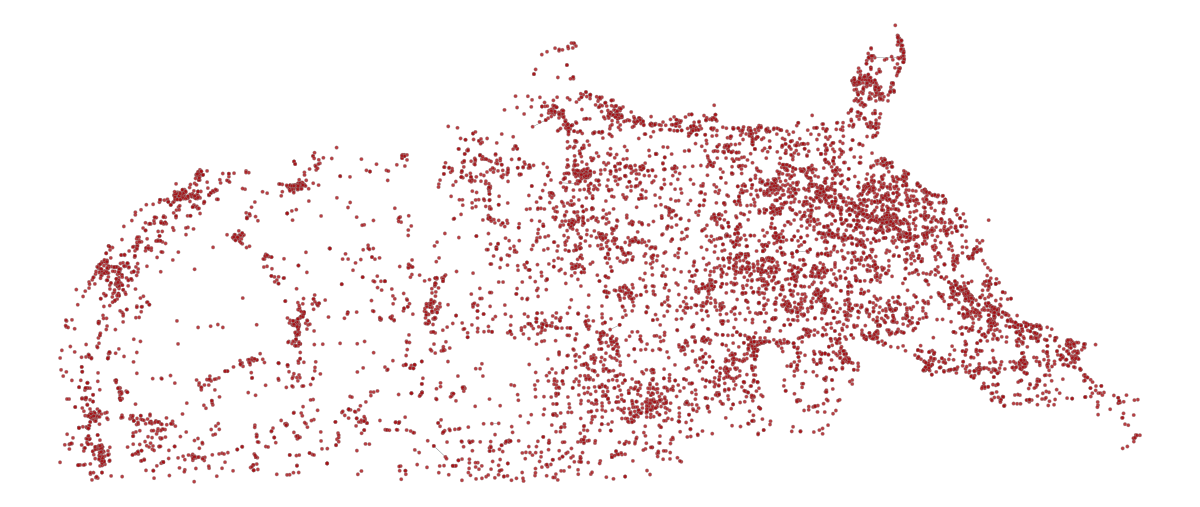

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f90e317c790, at 0x7f90e31bb750>

In [71]:
graph_draw(subgraph, pos=subgraph.vp.pos, bg_color=[0,0,0,0])

In [ ]:
subgraph

In [16]:
list(subgraph.vp.pos)

: 

In [ ]:
eigval, eigvec = eigenvector(subgraph, subgraph.ep.voltage)

In [2]:
show_config()

version: 2.58 (commit d1cd7c2d, )
gcc version: 12.3.0
compilation flags: -DBOOST_ALLOW_DEPRECATED_HEADERS -DNDEBUG -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/kerple/miniconda3/envs/transmission_lines/include -I/home/kerple/miniconda3/envs/transmission_lines/include -fopenmp -O3 -fvisibility=default -fvisibility-inlines-hidden -Wno-deprecated -Wall -Wextra -ftemplate-backtrace-limit=0 -fvisibility-inlines-hidden -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/kerple/miniconda3/envs/transmission_lines/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/graph-tool-suite_1700438747562/work=/usr/local/src/conda/graph-tool-base-2.58 -fdebug-prefix-map=/home/kerple/miniconda3/envs/transmission_lines=/usr/local/src/conda-prefix -I/home/kerple/miniconda3/envs/transmission_lines/include -std=c++17 -O3 -Wl,-O2 -Wl,--sort-common -Wl,--as-needed -Wl,-z,relro -Wl,-z,now -Wl,--